Greetings! 

This brief guide shows you how to:   

1. Train a "climate-invariant" neural network on training data from a cold ocean-like simulation,  
2. Show that this "climate-invariant" neural network generalizes much better than a standard net.  

To learn more about "climate-invariant" machine learning, check out our arXiv preprint [at this link](https://arxiv.org/abs/2112.08440)  

Download the data required to run this notebook from the following repository: TODO

# First, let's build our data generator to feed data to our neural nets

## To get started

Make sure you are using the right Python environment, for instance this one: [https://github.com/tbeucler/CBRAIN-CAM/blob/master/cbrain/env_gpu.yml]. 

You can refer to this page [https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file] to create a conda environment from a `yml` file, noting that it is usually impossible to get the exact same version of the packages because of frequent conda updates.  

Below, write down the path where you stored the training/test sets and the norm files

In [23]:
path_data = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/2023_15_02_Reduced_Data/'

We start by importing the climate-invariant utilities from the repository. If you are not in the same folder as `/cbrain/`, you can create a symlink (for instance using `ln -s`) to the `/cbrain/` folder of the repository containing all the utilities

In [24]:
from cbrain.climate_invariant import *
from cbrain.climate_invariant_utils import *

## Below is how we would build a standard or "brute-force" data generator `train_gen_BF`.

1. We would first specify the input variables `in_vars`, the output variables `out_vars`, and the path of the training set `path_train`. 

In [3]:
in_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX'] # We take the large-scale climate state as inputs
out_vars = ['PHQ','TPHYSTND','QRL','QRS'] # and we output the response of clouds/storms to these climate conditions
#path_train = path_data + '2021_03_18_O3_TRAIN_M4K.nc'
path_train = path_data+'2023_15_02_RG_TEST_M4K_red.nc'

2. To make sure all outputs have the same units (in our case W/m$^2 $), we multiply the raw outputs by the right physical constants, stored in a dictionary called `scale_dict`. 

In [4]:
import pickle
scale_dict = pickle.load(open(path_data+'009_Wm2_scaling.pkl','rb'))

3. We scale the inputs to [-1,1] by subtracting their mean before dividing them by their range. The means and ranges are stored in a normalization file stored in `path_input_norm`. 

In [5]:
path_input_norm = path_data + '2021_01_24_NORM_O3_small.nc'

4. We are now ready to build our first data generator!

In [7]:
train_gen_BF = DataGeneratorCI(
    data_fn = path_train,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path_input_norm,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict
)

## Now, we would like to build a "climate-invariant" data generator `train_gen_CI`, which requires a few more steps

### First, we have to create one standard generator per input rescaling. This will help us renormalize the inputs to [-1,1] every time we feed them to the neural network. 

1. First, let's define the path to the three normalization files for the three input rescalings:
Relative humidity `RH`, plume buoyancy `BMSE`, and normalized latent heat flux `LHF_nsDELQ` 

In [8]:
path_norm_RH = path_data + '2021_02_01_NORM_O3_RH_small.nc'
path_norm_BMSE = path_data + '2021_06_16_NORM_BMSE_small.nc'
path_norm_LHF_nsDELQ = path_data + '2021_02_01_NORM_O3_LHF_nsDELQ_small.nc'

2. We can now define one data generator per input rescaling

In [9]:
def train_gen_rescaling(input_rescaling):
    return DataGeneratorCI(
        data_fn = path_train,
        input_vars = input_rescaling,
        output_vars = out_vars,
        norm_fn = path_input_norm,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict)

In [10]:
train_gen_RH = train_gen_rescaling(in_vars)
train_gen_BMSE = train_gen_rescaling(in_vars)
train_gen_LHF_nsDELQ = train_gen_rescaling(in_vars)

### Then, the normalization factors of these generators can be combined to form a "climate-invariant" data generator `train_gen_CI`

In [11]:
train_gen_CI = DataGeneratorCI(
    data_fn = path_train,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path_input_norm,
    input_transform = ('mean','maxrs'),
    output_transform = scale_dict,
    Qscaling = 'RH',
    Tscaling = 'BMSE',
    LHFscaling = 'LHF_nsDELQ',
    hyam=hyam, hybm=hybm, # Arrays to define mid-levels of hybrid vertical coordinate
    inp_sub_Qscaling=train_gen_RH.input_transform.sub, # What to subtract from RH inputs
    inp_div_Qscaling=train_gen_RH.input_transform.div, # What to divide RH inputs by
    inp_sub_Tscaling=train_gen_BMSE.input_transform.sub,
    inp_div_Tscaling=train_gen_BMSE.input_transform.div,
    inp_sub_LHFscaling=train_gen_LHF_nsDELQ.input_transform.sub,
    inp_div_LHFscaling=train_gen_LHF_nsDELQ.input_transform.div
)

### Before proceeding to the neural nets, we may as well already define the data generator in the generalization test climate while we are building data generators

We build these data generators exactly like we built the previous ones, except that we replace the `data_fn` argument with the path to the test generalization set `path_test` 

In [20]:
path_test = path_data + '2021_03_18_O3_TRAIN_P4K.nc'
path_test = '/fast/tbeucler/climate_invariant/aquaplanet/' + '2021_03_18_O3_TRAIN_P4K.nc'

In [21]:
test_gen_BF = DataGeneratorCI(
    data_fn = path_test,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path_input_norm,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict
)

In [73]:
test_gen_CI = DataGeneratorCI(
    data_fn = path_test,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = path_input_norm,
    input_transform = ('mean','maxrs'),
    output_transform = scale_dict,
    Qscaling = 'RH',
    Tscaling = 'BMSE',
    LHFscaling = 'LHF_nsDELQ',
    hyam=hyam, hybm=hybm, # Arrays to define mid-levels of hybrid vertical coordinate
    inp_sub_Qscaling=train_gen_RH.input_transform.sub, # What to subtract from RH inputs
    inp_div_Qscaling=train_gen_RH.input_transform.div, # What to divide RH inputs by
    inp_sub_Tscaling=train_gen_BMSE.input_transform.sub,
    inp_div_Tscaling=train_gen_BMSE.input_transform.div,
    inp_sub_LHFscaling=train_gen_LHF_nsDELQ.input_transform.sub,
    inp_div_LHFscaling=train_gen_LHF_nsDELQ.input_transform.div
)

# Now, we are ready to build our neural nets

## We use the same architecture for both neural nets, i.e. 7 layers of 128 neurons

Here's a generic function to define a 7 layers, 128 neurons neural network using the Keras functional API

In [37]:
def NN_model(inp):
    densout = Dense(128, activation='linear')(inp)
    densout = LeakyReLU(alpha=0.3)(densout)
    for i in range (6):
        densout = Dense(128, activation='linear')(densout)
        densout = LeakyReLU(alpha=0.3)(densout)
    dense_out = Dense(120, activation='linear')(densout)
    return tf.keras.models.Model(inp, dense_out)

The "brute-force" and "climate-invariant" neural networks both have 64 inputs, but we have to make sure they have different names to define separate models

In [38]:
inp_BF = Input(shape=(64,))
NN_BF = NN_model(inp_BF) # Brute-force model

inp_CI = Input(shape=(64,))
NN_CI = NN_model(inp_CI) # Climate-invariant model

The summary attribute is quite helpful to make sure we properly defined each model

In [39]:
NN_BF.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               8320      
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 128)               0   

## We compile both models so that they use the Adam optimizer and the mean-squared error of the outputs (in W$^{2}$/m$^{4}$) as their loss function

In [40]:
NN_BF.compile(tf.keras.optimizers.Adam(), loss=mse)
NN_CI.compile(tf.keras.optimizers.Adam(), loss=mse)

## Before training, we use one last trick that allows us to track the loss of the neural network on the test generalization set at the end of each epoch!

That way, we can see from the get go whether our models generalize well or not!

This class was adapted from [https://stackoverflow.com/questions/47731935/using-multiple-validation-sets-with-keras]

In [41]:
class AdditionalValidationSets(Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            valid_generator,valid_name = validation_set
            results = self.model.evaluate_generator(generator=valid_generator)

            for metric, result in zip(self.model.metrics_names,[results]):
                valuename = valid_name + '_' + metric
                self.history.setdefault(valuename, []).append(result)

# Finally, we can train our neural nets and compare them!

## First, the "brute-force" neural net, `NN_BF`

Below is the trick to follow the loss on the test generalization set 

In [42]:
history_BF = AdditionalValidationSets([(test_gen_BF,'Generalization MSE')])

We save our model at the end of each epoch that decreases the loss to be cautious. 

Note that in our paper, we also use the callback below to only save the model that has the best validation loss. That way, we avoid overfitting, which we cannot do here because we only have a training set and a test generalization set.

Write down the path where you would like to save your model below

In [43]:
path_BF = path_data + 'NN_BF.hdf5'
mcp_save_BF = ModelCheckpoint(path_BF)

Ready to train the model for `Nep` epochs

In [44]:
Nep = 10

In [49]:
NN_BF.fit_generator(train_gen_BF, epochs=Nep, callbacks=[mcp_save_BF,history_BF])

We save the learning curves because they contain precious information on the training, overfitting, and generalization ability of the neural net (see SI D2 of our study)

Write the path where you want to save the learning curves below...

In [47]:
path_BF_Learning_Curve = path_data + 'NN_BF_Learning_Curves.pkl'

... and save them as the `hist` entry of our Learning Curve dictionary:

In [48]:
hf = open(path_BF_Learning_Curve,'wb')
data = {'hist':history_BF.history}
pickle.dump(data,hf)
hf.close()

## Then, the "climate invariant" neural net, `NN_CI`

We repeat the same steps...

In [56]:
history_CI = AdditionalValidationSets([(test_gen_CI,'Generalization MSE')])

path_CI = path_data + 'NN_CI.hdf5'
mcp_save_CI = ModelCheckpoint(path_CI)

Nep = 10

...and train a climate invariant neural net this time

In [74]:
NN_CI.fit_generator(train_gen_CI, epochs=Nep, callbacks=[mcp_save_CI,history_CI])

Again, we recommend saving the learning curves:

In [75]:
path_CI_Learning_Curve = path_data + 'NN_CI_Learning_Curves.pkl'

In [76]:
hf = open(path_CI_Learning_Curve,'wb')
data = {'hist':history_CI.history}
pickle.dump(data,hf)
hf.close()

# Now, we can cleanly compare the performance and generalization ability of both neural nets

Here, we use the learning curves to simply compared the overall mean-squared error on both the training and the generalization test set. Getting maps of spatio-temporal performance requires a bit more work, see e.g. notebook [https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/073_CI_Results_Figure.ipynb]

Just in case you don't have time to train both neural nets, we included the learning curves in the same data folder

## Skip the step below if you trained both neural nets and saved the learning curves

Load the examples below; this is of course not needed if you already trained the neural nets yourself (kudos to you if you did). 

In [85]:
path_BF_Learning_Curve = path_data + 'NN_BF_Learning_Curve_Example.pkl'
hf = open(path_BF_Learning_Curve,'rb')
Learning_Curve_BF = pickle.load(hf)
hf.close()
Learning_Curve_BF_train = Learning_Curve_BF['hist']['loss']
Learning_Curve_BF_test = Learning_Curve_BF['hist']['trainP4K_loss']

In [86]:
path_CI_Learning_Curve = path_data + 'NN_CI_Learning_Curve_Example.pkl'
hf = open(path_CI_Learning_Curve,'rb')
Learning_Curve_CI = pickle.load(hf)
hf.close()
Learning_Curve_CI_train = Learning_Curve_CI['hist']['loss']
Learning_Curve_CI_test = Learning_Curve_CI['hist']['trainP4K_loss']

## Rename your learning curves here

Call the learning curve of the "brute force" model on the training set `Learning_Curve_BF_train`,  
the learning curve of the "climate-invariant" model on the test set `Learning_Curve_CI_test`,   
etc.

Define the epoch vector for plotting below

In [87]:
Nep = 20 # Use the same number of epochs as you used for training
epoch = np.arange(1,Nep+1)

## And we are now ready for plotting

Let's first define the fontsize, linewidth, and scatter size of our plots

In [92]:
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator

In [89]:
fz = 15 # Here we define the fontsize 
lw = 2 # the linewidth
siz = 75 # and the scattered dots' size

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

First, we can look at the performance of our neural networks over the training set: the mean-squared error are very similar, suggesting that there is not trade-off between the "brute-force" and "climate-invariant" mappings when it comes to fitting the training set.

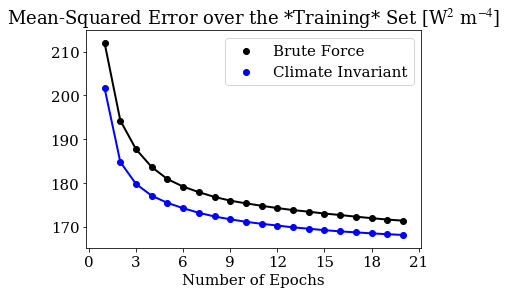

In [98]:
plt.plot(epoch,Learning_Curve_BF_train,color='k')
plt.scatter(epoch,Learning_Curve_BF_train,color='k',label='Brute Force')

plt.plot(epoch,Learning_Curve_CI_train,color='b')
plt.scatter(epoch,Learning_Curve_CI_train,color='b',label='Climate Invariant')

plt.legend()

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Number of Epochs')
plt.title('Mean-Squared Error over the *Training* Set [W$^{2}$ m$^{-4}$]');

However, the "climate-invariant" neural network generalizes significantly better than the "brute force" one, as shown below. 

You could check that the "climate-invariant" neural network performs almost as well as the "brute force" network directly trained on the generalization test set! This shows how physics can really help choose the right mapping to learn for your neural net.

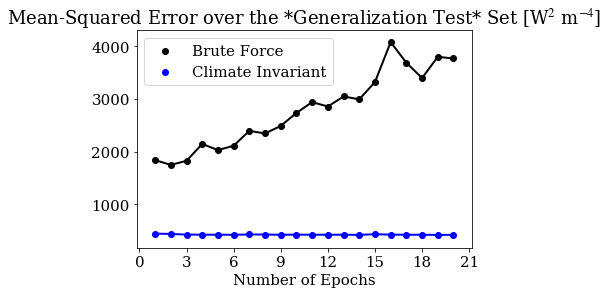

In [99]:
plt.plot(epoch,Learning_Curve_BF_test,color='k')
plt.scatter(epoch,Learning_Curve_BF_test,color='k',label='Brute Force')

plt.plot(epoch,Learning_Curve_CI_test,color='b')
plt.scatter(epoch,Learning_Curve_CI_test,color='b',label='Climate Invariant')

plt.legend()

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Number of Epochs')
plt.title('Mean-Squared Error over the *Generalization Test* Set [W$^{2}$ m$^{-4}$]');

Zooming in on the "climate-invariant" NN only, we see that the loss over the generalization set decreases during training, even though we are training on a training set that is 8K colder! This shows that the "climate-invariant" mapping allows us to continuously learn about the generalization test set while learning about the much colder training set.

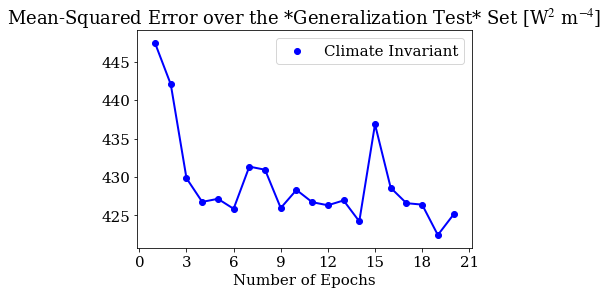

In [100]:
plt.plot(epoch,Learning_Curve_CI_test,color='b')
plt.scatter(epoch,Learning_Curve_CI_test,color='b',label='Climate Invariant')

plt.legend()

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Number of Epochs')
plt.title('Mean-Squared Error over the *Generalization Test* Set [W$^{2}$ m$^{-4}$]');